<table>
<tr>                                                                                   
     <th>
         <div style='padding:15px;color:#030aa7;font-size:240%;text-align: center;font-style: italic;font-weight: bold;font-family: Georgia, serif'>
             <a href="https://www.kaggle.com/datasets/burakhmmtgl/energy-molecule/data">Ground State Energies of 16,242 Molecules<br>Analyse en Composantes Principales (ACP)</a></div>
     </th>
     <th><img src="https://raw.githubusercontent.com/rbizoi/MachineLearning/refs/heads/master/images/potential-energy.png" width="96"></th>
 </tr>
</table>

<div style='text-align: center'>
<img src="https://raw.githubusercontent.com/rbizoi/MachineLearning/refs/heads/master/images/periodic_table.png" width="512">
</div>

# <b><div style='padding:15px;background-color:#d8dcd6;color:#030aa7;font-size:120%;text-align: left'>Import libriries</div></b>

In [1]:
import pandas as pd, numpy as np, seaborn as sns, warnings, os, sys, time, copy as cp
from datetime import datetime as dt
from matplotlib import pyplot as plt

import matplotlib.font_manager as fm
import plotly.express as px
import plotly.graph_objs as go

font1 = fm.FontProperties(size=20)
font2 = fm.FontProperties(size=24)

warnings.filterwarnings(action="ignore")

if int(str(sns.__version__).split('.')[1]) > 8 : 
    plt.style.use('seaborn-v0_8-darkgrid')
else:
    plt.style.use('seaborn-darkgrid')
sns.set(font_scale=2)

In [2]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster
from sklearn.cluster import KMeans

## <b><div style='padding:15px;background-color:#d8dcd6;color:#030aa7;font-size:120%;text-align: left'>Outils du document</div></b>

In [3]:
repertoireRacine  = '.'
nomProjet         = 'Analyse en Composantes Principales-Ground State Energies'

repertoireProjet  = os.path.join(repertoireRacine, nomProjet)
repertoireDonnees = os.path.join(repertoireProjet, 'repertoire.donnees')
repertoireImages  = os.path.join(repertoireProjet, 'repertoire.images')


def controleExistenceRepertoire( repertoire, create_if_needed=True):
    """Voir si le répertoire existe. S'il n'existe pas il est créé."""
    path_exists = os.path.exists(repertoire)
    if path_exists:
        if not os.path.isdir(repertoire):
            raise Exception("Trouvé le nom  "+repertoire +" mais c'est un fichier, pas un répertoire")
            # return False
        return True
    if create_if_needed:
        os.makedirs(repertoire)

def sauvegarderImage( fichier):
    """Enregistrez la figure. Appelez la méthode juste avant plt.show ()."""
    controleExistenceRepertoire(repertoireImages)
    plt.savefig(os.path.join(repertoireImages,
                             fichier+f"--{dt.now().strftime('%Y_%m_%d_%H.%M.%S')}.png"), 
                             dpi=600, 
                             bbox_inches='tight')

def sauvegarderImageSNS( sns_plot, fichier):
    """Enregistrez la figure. Appelez la méthode juste avant plt.show ()."""
    controleExistenceRepertoire(repertoireImages)
    fig = sns_plot.get_figure()
    fig.savefig(os.path.join(repertoireImages,fichier+'.png'))
    
controleExistenceRepertoire(repertoireProjet);
controleExistenceRepertoire(repertoireDonnees);
controleExistenceRepertoire(repertoireImages);

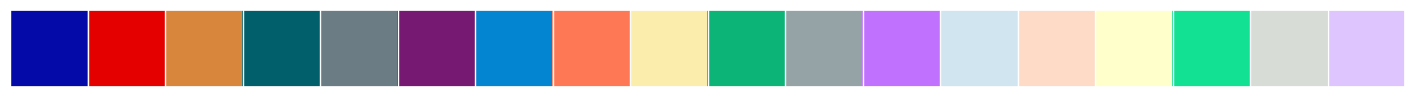

In [4]:
palette = [ "#030aa7", "#e50000", "#d8863b", "#005f6a", "#6b7c85", "#751973", 
            "#0485d1", "#ff7855", "#fbeeac", "#0cb577", "#95a3a6", "#c071fe", 
            "#d1e5f0", "#fddbc7", "#ffffcb", "#12e193", "#d8dcd6", "#dfc5fe", 
          ]
sns.palplot(sns.color_palette(palette))

# <b><div style='padding:15px;background-color:#d8dcd6;color:#030aa7;font-size:120%;text-align: left'>Lecture des données</div></b>

In [5]:
donnees =  pd.read_parquet('../donnees/Ground State Energies of 16.242 Molecules/roboBohr.gzip', engine='pyarrow')
cible = 'Eat'
donnees.sample(10)

0          1          2          3          4          5  \
pubchem_id                                                                      
33024        73.516695  21.185814  20.687098  18.612728  18.590608  17.070029   
31279        53.358707  15.264107  15.225168  14.235151  14.235099  12.714980   
7171         73.516695  18.655482  13.789413  13.787545  13.653894  13.652537   
30664        73.516695  17.865639  17.715150  12.859585  12.818133  12.595804   
19657       388.023441  65.520275  39.182607  39.148913  39.095657  22.465759   
1055        332.344906  42.297032  39.276177  39.256475  39.254413  18.686153   
14238        36.858105  14.185760  14.175565  13.069632  12.741619  12.663051   
12590        53.358707  19.147679  19.147641  12.965876  12.964644  12.460271   
14522        53.358707  15.185250  15.182977  15.182248  12.501760  12.435710   
20502        73.516695  20.664349  20.358115  17.989491  17.715753  13.829983   

                    6          7          8          9  ...  1266  1267  1268  \
pubchem_id                                              ...                     
33024       16.649239  15.767164  15.288471  13.955358  ...   0.0   0.0   0.0   
31279       12.714635   9.094726   9.082991   7.934761  ...   0.0   0.0   0.0   
7171        13.652407  13.652074  12.537586  12.518528  ...   0.0   0.0   0.0   
30664       10.368447  10.350082   7.420377   7.335951  ...   0.0   0.0   0.0   
19657       22.458808  22.397147  18.538927  18.337745  ...   0.0   0.0   0.0   
1055        18.233937  17.867725  17.843894  16.434838  ...   0.0   0.0   0.0   
14238        7.846435   7.703355   7.620566   7.616332  ...   0.0   0.0   0.0   
12590       12.458926  12.448846  12.448814   8.450705  ...   0.0   0.0   0.0   
14522       12.435222  12.400034  12.394153  12.393646  ...   0.0   0.0   0.0   
20502       13.828244  13.653875  13.653581  13.653490  ...   0.0   0.0   0.0   

            1269  1270  1271  1272  1273  1274        Eat  
pubchem_id                                                 
33024        0.0   0.0   0.0   0.0   0.0   0.0 -10.200764  
31279        0.0   0.0   0.0   0.0   0.0   0.0  -7.391101  
7171         0.0   0.0   0.0   0.0   0.0   0.0 -12.007294  
30664        0.0   0.0   0.0   0.0   0.0   0.0  -5.156083  
19657        0.0   0.0   0.0   0.0   0.0   0.0  -9.753900  
1055         0.0   0.0   0.0   0.0   0.0   0.0 -12.215395  
14238        0.0   0.0   0.0   0.0   0.0   0.0  -6.595890  
12590        0.0   0.0   0.0   0.0   0.0   0.0  -8.417568  
14522        0.0   0.0   0.0   0.0   0.0   0.0 -11.092437  
20502        0.0   0.0   0.0   0.0   0.0   0.0 -14.868954  

[10 rows x 1276 columns]

In [6]:
donnees.shape

(16242, 1276)

## <b><div style='padding:15px;background-color:#d8dcd6;color:#030aa7;font-size:120%;text-align: left'>Structuration des données</div></b>
<div style='padding:15px;color:#030aa7;font-size:100%;text-align: left;font-family: Georgia, serif'>Les données sont structurées dans un tableau ou matrice à n lignes et p colonnes. Chacune des n lignes représente un individu et chacune des p colonnes une variable. Pour une analyse en composantes principales, la variables sont uniquement quantitatives : la matrice est donc constituée de valeurs numériques.</div> <img src="https://raw.githubusercontent.com/rbizoi/MachineLearning/refs/heads/master/images/acp_representation_variables.png" width="512">

## <b><div style='padding:15px;background-color:#d8dcd6;color:#030aa7;font-size:120%;text-align: left'>Centrage et réduction des données</div></b>
<table>
<tr>
<th><img src="https://raw.githubusercontent.com/rbizoi/MachineLearning/refs/heads/master/images/moyenne.png"></th>
<th><img src="https://raw.githubusercontent.com/rbizoi/MachineLearning/refs/heads/master/images/ecart_type.png"></th>
<th><img src="https://raw.githubusercontent.com/rbizoi/MachineLearning/refs/heads/master/images/centrage_reduction.png"></th>
</tr>
</table>

In [7]:
modelStd = StandardScaler()
modelStd.fit(donnees.drop(columns=cible))

donnees[donnees.drop(columns=cible).columns] = modelStd.transform(donnees.drop(columns=cible))
donnees.sample(10)

0         1         2         3         4         5  \
pubchem_id                                                               
5918       -0.550877 -0.694199 -0.526752 -0.421579 -0.260307 -0.495844   
74005      -0.550877 -0.686577 -0.528074 -0.729384 -0.624567 -0.504621   
247        -0.372795 -0.268376 -0.051158 -0.572298 -0.466183 -0.291325   
37894      -0.372795 -0.544762 -0.818299 -0.899440 -0.830052 -0.797030   
36113      -0.550877 -0.384753 -0.876984 -0.737396 -0.621531 -0.496357   
5310       -0.372795 -0.192337 -0.809865 -0.892186 -0.813389 -0.761825   
441        -0.372795 -0.197070 -0.227087 -0.111837 -0.410590 -0.761636   
11816      -0.372795 -0.220841  0.000307  0.006392  0.102871 -0.265471   
7118       -0.372795 -0.439345 -0.239105 -0.104554  0.114902  0.475048   
10496      -0.372795 -0.184600  0.048534  0.009480  0.257607  0.408662   

                   6         7         8         9  ...      1266      1267  \
pubchem_id                                          ...                       
5918       -0.357471 -0.221070 -0.078913 -1.361047  ... -0.049014 -0.049015   
74005      -0.373613 -0.226080 -0.098054  0.040096  ... -0.049014 -0.049015   
247        -0.137641  0.036183 -0.432751 -0.839281  ... -0.049014 -0.049015   
37894      -0.689112 -0.578757 -0.460776 -0.356876  ... -0.049014 -0.049015   
36113      -0.380531 -0.233779 -0.091862  0.059707  ... -0.049014 -0.049015   
5310       -0.677703 -0.581000 -0.456456 -0.353292  ... -0.049014 -0.049015   
441        -0.675340 -0.568038 -0.936377 -0.891975  ... -0.049014 -0.049015   
11816      -0.332877 -0.184569 -0.091065  0.060145  ... -0.049014 -0.049015   
7118       -0.380904 -0.233589 -0.091962  0.059581  ... -0.049014 -0.049015   
10496       0.614843  0.060797  0.215525  0.262036  ... -0.049014 -0.049015   

                1268      1269     1270      1271      1272      1273  \
pubchem_id                                                              
5918       -0.049013 -0.088421 -0.04901 -0.049013 -0.065791 -0.049013   
74005      -0.049013 -0.088421 -0.04901 -0.049013 -0.065791 -0.049013   
247        -0.049013 -0.088421 -0.04901 -0.049013 -0.065791 -0.049013   
37894      -0.049013 -0.088421 -0.04901 -0.049013 -0.065791 -0.049013   
36113      -0.049013 -0.088421 -0.04901 -0.049013 -0.065791 -0.049013   
5310       -0.049013 -0.088421 -0.04901 -0.049013 -0.065791 -0.049013   
441        -0.049013 -0.088421 -0.04901 -0.049013 -0.065791 -0.049013   
11816      -0.049013 -0.088421 -0.04901 -0.049013 -0.065791 -0.049013   
7118       -0.049013 -0.088421 -0.04901 -0.049013 -0.065791 -0.049013   
10496      -0.049013 -0.088421 -0.04901 -0.049013 -0.065791 -0.049013   

                1274        Eat  
pubchem_id                       
5918       -0.049061  -6.949788  
74005      -0.049061 -13.192315  
247        -0.049061  -7.631695  
37894      -0.049061 -11.839976  
36113      -0.049061 -17.195408  
5310       -0.049061 -16.193446  
441        -0.049061  -6.111966  
11816      -0.049061 -14.342508  
7118       -0.049061 -10.338152  
10496      -0.049061 -10.310263  

[10 rows x 1276 columns]

## <b><div style='padding:15px;background-color:#d8dcd6;color:#030aa7;font-size:120%;text-align: left'>Analyse en composantes principales</div></b>

<table>
<tr>
<th><div style='padding:15px;color:#030aa7;font-size:120%;text-align: center;font-family: Georgia, serif'>Quelle est la meilleure représentation simplifiée ?</div></th>
<th><div style='padding:15px;color:#030aa7;font-size:120%;text-align: center;font-family: Georgia, serif'>Recherche du meilleur axe de projection</div></th>
</tr>    
<tr>
<th><img src="https://raw.githubusercontent.com/rbizoi/MachineLearning/refs/heads/master/images/acp_analogie_photo.png" width="512"></th>
<th><img src="https://raw.githubusercontent.com/rbizoi/MachineLearning/refs/heads/master/images/acp_projection_axe.png" width="512"></th>
</tr>
</table>    
<div style='padding:15px;color:#030aa7;font-size:120%;text-align: left;font-family: Georgia, serif'>A l'évidence, c'est la vue de profil. La raison est que l'image projetée du chameau dans ce plan est plus proche de l'image initiale dans le sens ou la variance des points servant à sa représentation est plus grande et donc restitue mieux la variance des points d'origine.</div>
<table>
<tr>
<th><img src="https://raw.githubusercontent.com/rbizoi/MachineLearning/refs/heads/master/images/axe_variance_max.png"></th>
<th><img src="https://raw.githubusercontent.com/rbizoi/MachineLearning/refs/heads/master/images/max_dist.png"></th>
</tr>
</table>

In [8]:
modelPCA = PCA(svd_solver='full')
modelPCA.fit(donnees.drop(columns=cible))

PCA(svd_solver='full')

In [9]:
modelPCA.explained_variance_ratio_.cumsum()*100

array([ 62.15638166,  79.64284135,  86.04908724, ..., 100.        ,
       100.        , 100.        ])

In [10]:
modelPCA.explained_variance_*100

array([7.92542662e+04, 2.22966089e+04, 8.16846644e+03, ...,
       3.28694221e-28, 3.28694221e-28, 3.28694221e-28])

In [11]:
modelPCA.n_components_

1275

In [12]:
inertie = pd.DataFrame(modelPCA.explained_variance_ratio_,columns=['Inertie']) 
inertie['Label'] = np.round(modelPCA.explained_variance_ratio_.cumsum()*100,2)
inertie['Dimension'] = range(1,len(modelPCA.explained_variance_)+1)
inertie['Inertie'] = np.round(inertie['Inertie']*100,2)
dim = modelPCA.n_components_
inertie = inertie[inertie['Dimension']<= dim]

### <b><div style='padding:15px;background-color:#d8dcd6;color:#030aa7;font-size:120%;text-align: left'>Choix du nombre des dimensions</div></b>
<div style='color:#030aa7;font-size:120%;text-align: left'>La qualité globale est mesurée par la part d'inertie expliquée. La valeur est choisie de sorte que cette part d'inertie expliquée soit supérieure à une valeur seuil fixée a priori par l'utilisateur.<br>C'est souvent le seul critère employé.<br><b>min 75%</b><br><br><b>95%</b></div>

In [13]:
sum(modelPCA.explained_variance_ratio_.cumsum()*100 <= 95) + 1

9

In [14]:
inertie[inertie.Dimension <= 10]

Inertie  Label  Dimension
0    62.16  62.16          1
1    17.49  79.64          2
2     6.41  86.05          3
3     3.21  89.26          4
4     1.83  91.08          5
5     1.48  92.57          6
6     1.13  93.69          7
7     0.84  94.54          8
8     0.64  95.18          9
9     0.56  95.73         10

### <b><div style='padding:15px;background-color:#d8dcd6;color:#030aa7;font-size:120%;text-align: left'>Pourcentage d'inertie(variance) associée à chaque dimension</div></b>

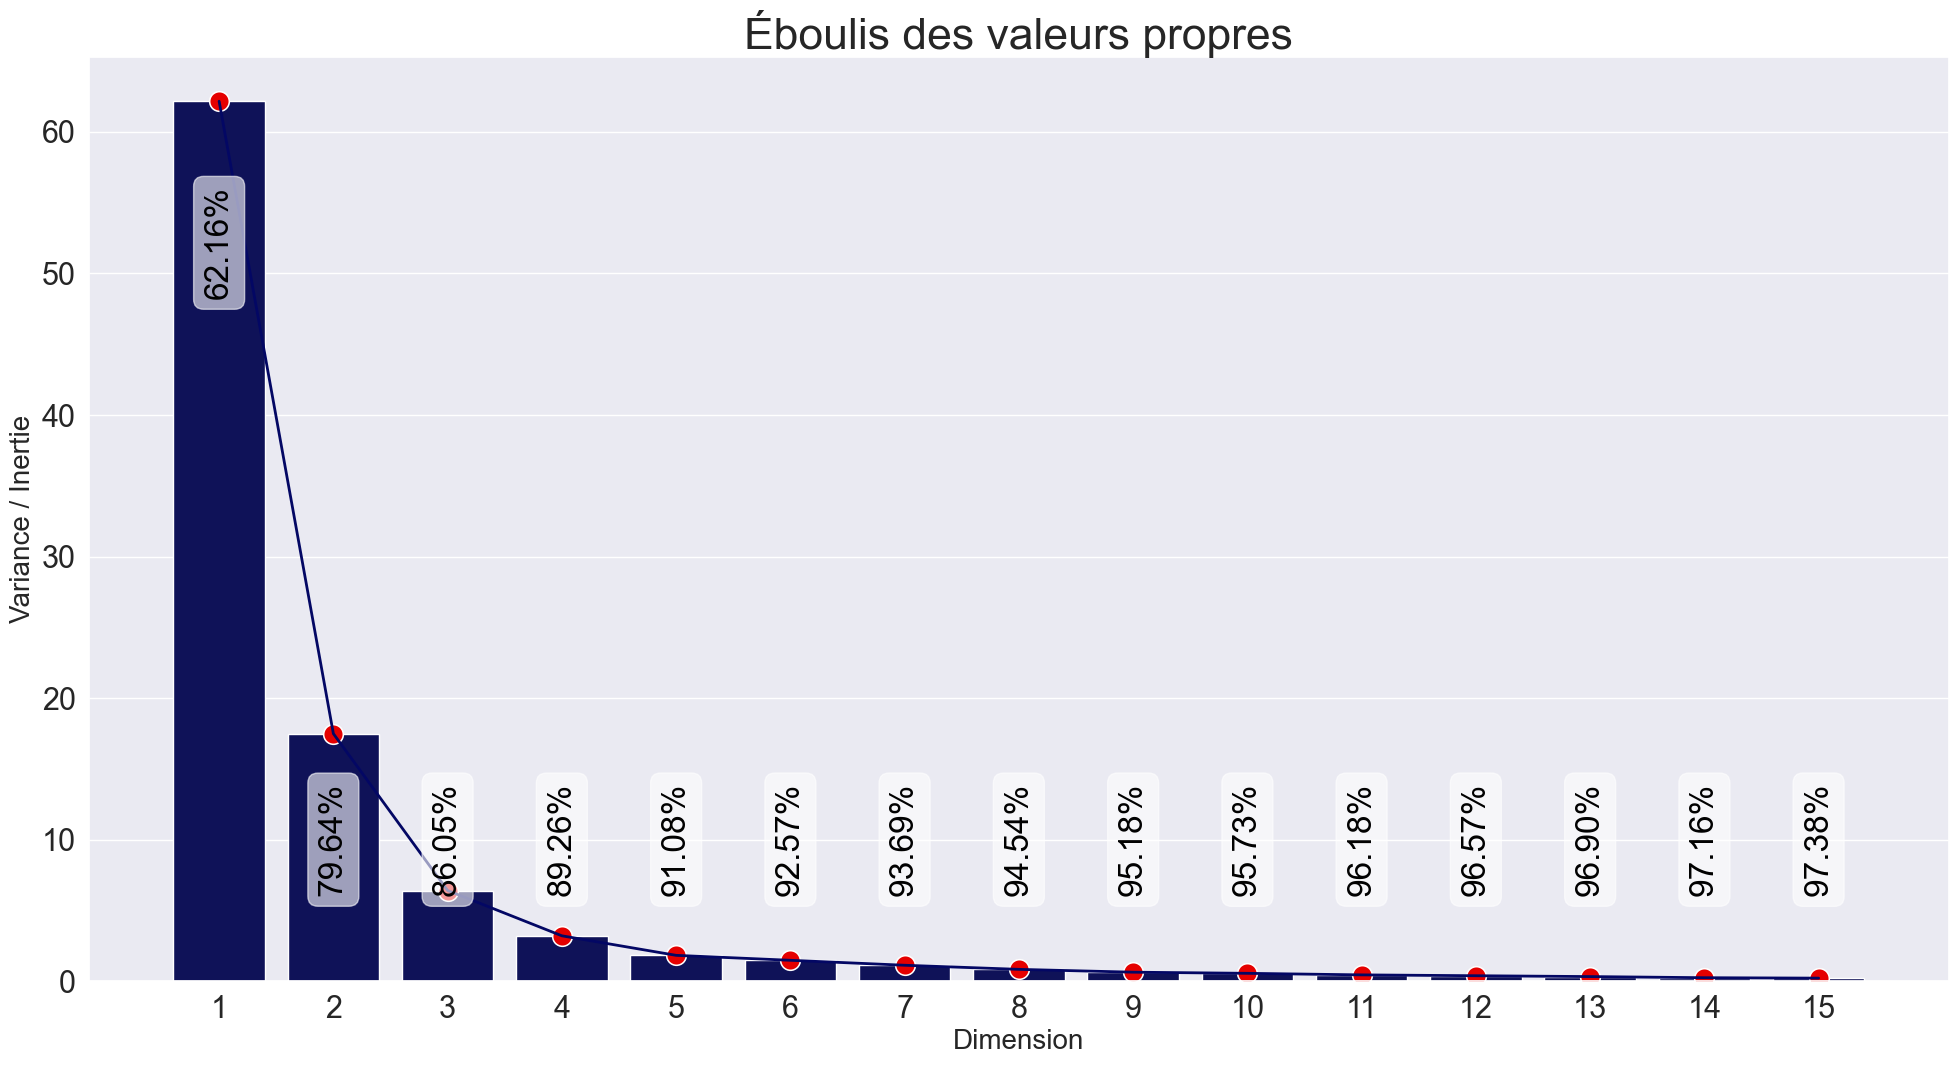

In [15]:
fig, ax = plt.subplots(figsize=(24,12));
graph = sns.barplot(x="Dimension",y='Inertie', data=inertie[inertie.Dimension <= 15], color="#030764", ax=ax)

for i,(nom,valeur) in enumerate(zip(inertie[inertie.Dimension <= 15].sort_values('Dimension').Label,inertie.sort_values('Dimension').Inertie)):
    # valeur = 0.1 if valeur - 0.1 < 0.1 else valeur - 0.1
    valeur = 10 if valeur - 10 < 10 else valeur - 10
    delta =  i 
    graph.text(
                delta ,
                valeur,
                f'{nom:0.2f}%',
                color='black',
                rotation='vertical',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.6),
                verticalalignment='center',
                horizontalalignment='center',
               )
    
graph = sns.lineplot( x=inertie[inertie.Dimension <= 15].Dimension - 1,
                      y='Inertie',
                      data=inertie,
                      estimator = None, 
                      lw        = 2, 
                      ci        = None,
                      color     = "#030764",
                      ax    = ax);

sns.scatterplot(x=inertie[inertie.Dimension <= 15].Dimension - 1,
                y     = 'Inertie',
                data  = inertie,
                s     = 200,
                # ci    = None, 
                color = "#e50000",
                ax    = ax);    
    
ax.set_xlabel('Dimension', fontproperties=font1)
ax.set_ylabel('Variance / Inertie', fontproperties=font1)
ax.set_title('Éboulis des valeurs propres', fontproperties=fm.FontProperties(size=32))

sauvegarderImage('Choix du nombre des dimensions02')
sns.set(font_scale=2)

### <b><div style='padding:15px;background-color:#d8dcd6;color:#030aa7;font-size:120%;text-align: left'>Règle de Kaiser</div></b>

<div style='color:#030aa7;font-size:120%;text-align: left'>On ne conserve que les valeurs propres supérieures à leur moyenne car les autres représentent moins de variabilité qu'une seule variable initiale.</div>

In [16]:
print(f'{100 / modelPCA.n_components_}')

0.0784313725490196


In [17]:
inertie[inertie.Inertie >= (100 / modelPCA.n_components_)]

Inertie  Label  Dimension
0     62.16  62.16          1
1     17.49  79.64          2
2      6.41  86.05          3
3      3.21  89.26          4
4      1.83  91.08          5
5      1.48  92.57          6
6      1.13  93.69          7
7      0.84  94.54          8
8      0.64  95.18          9
9      0.56  95.73         10
10     0.45  96.18         11
11     0.39  96.57         12
12     0.33  96.90         13
13     0.25  97.16         14
14     0.22  97.38         15
15     0.19  97.57         16
16     0.15  97.72         17
17     0.15  97.87         18
18     0.14  98.01         19
19     0.11  98.12         20
20     0.11  98.23         21
21     0.10  98.32         22
22     0.09  98.41         23
23     0.08  98.49         24

In [18]:
n_components,_ = inertie[inertie.Inertie >= (100 / modelPCA.n_components_)].shape
n_components = sum(modelPCA.explained_variance_ratio_.cumsum()*100 <= 95) + 1
n_components

9

### <b><div style='padding:15px;background-color:#d8dcd6;color:#030aa7;font-size:120%;text-align: left'>Transformation des données</div></b>

In [19]:
modelPCA = PCA(n_components=n_components).set_output(transform="pandas")
donneesACP = modelPCA.fit_transform((donnees.drop(columns=cible)))
donneesACP.columns = [f'Dimension{i:02d}' for i in range(1,n_components+1)]
donneesACP[cible] = donnees[cible]

<div style='padding:15px;color:#030aa7;font-size:120%;text-align: left;font-family: Georgia, serif'>Les nouvelles dimensions doivent être indépendantes deux à deux</div>

In [20]:
donneesACP.corr().style.format("{:0.1e}").background_gradient(cmap=plt.get_cmap('Blues'),axis=0)

### <b><div style='padding:15px;background-color:#d8dcd6;color:#030aa7;font-size:120%;text-align: left'>Représentation des individus</div></b>

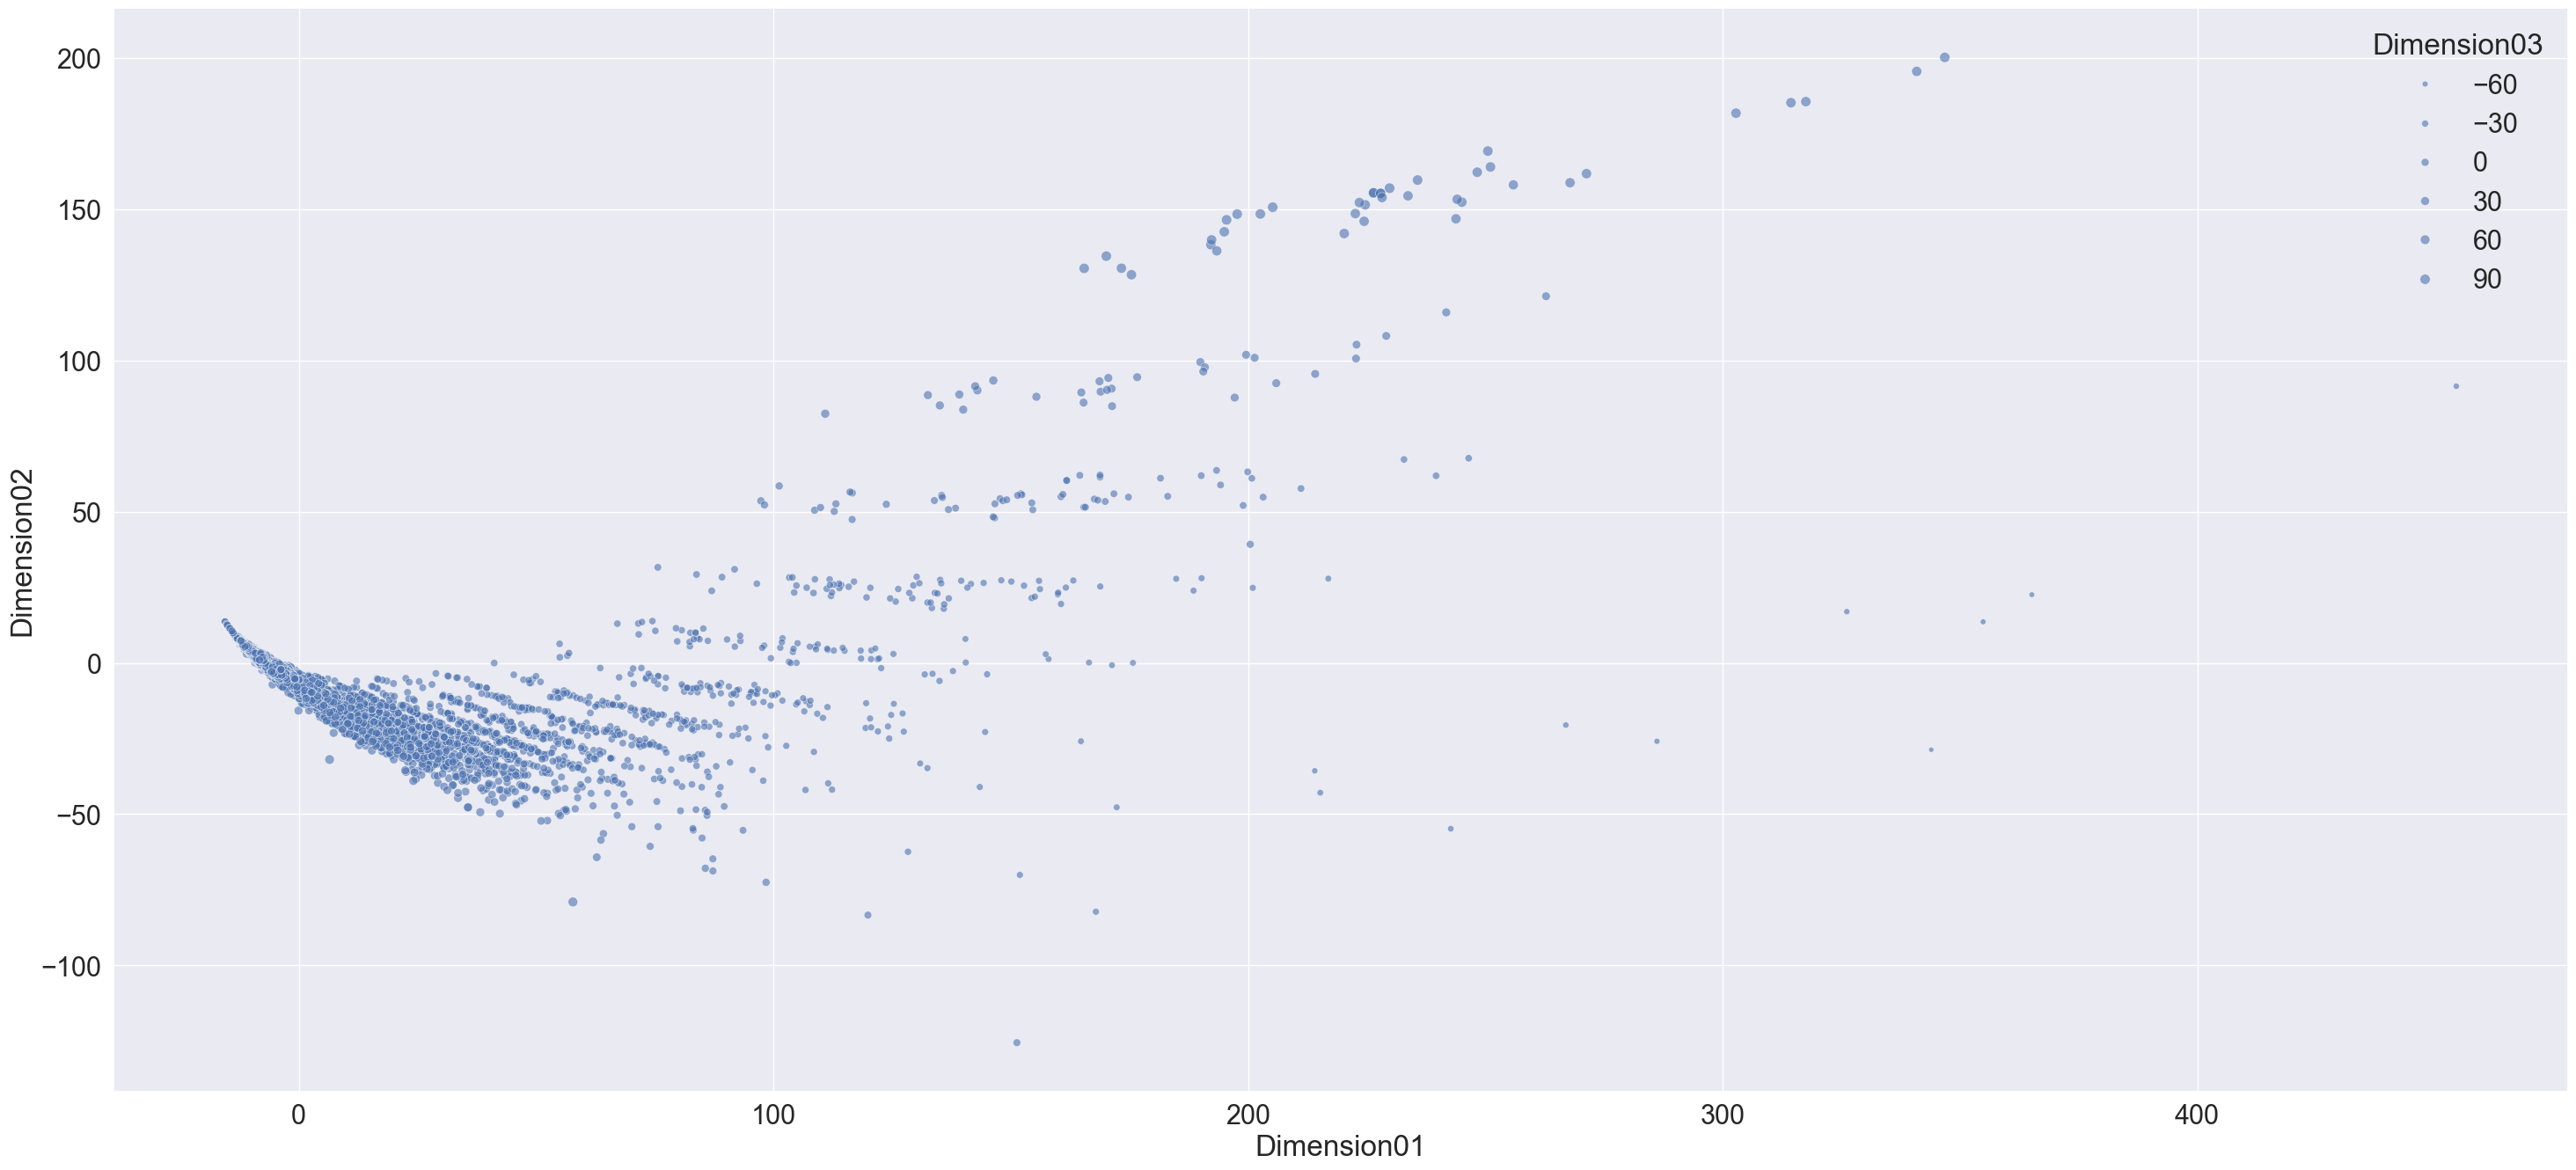

In [21]:
fig, ax = plt.subplots(figsize=(36,16));

sns.scatterplot(x       = 'Dimension01', 
                y       = 'Dimension02',
                size    = 'Dimension03', 
                # hue     = donneesACP[::1][cible], 
                data    = donneesACP[::1],
                s       = 500,
                palette = palette,
                alpha=0.6,
                ax=ax
                );

# sauvegarderImage('Représentation des individus')

#### <b><div style='padding:15px;background-color:#d8dcd6;color:#030aa7;font-size:120%;text-align: left'>Représentation des individus</div></b>

In [22]:
layout = go.Layout({"showlegend": False})
affichage = donneesACP[::1]
fig = px.scatter_3d(affichage, 
                    x='Dimension01', 
                    y='Dimension02', 
                    z='Dimension03',
                    color='Dimension04', 
                    size=(affichage.Eat - affichage.Eat.min()),
                    # symbol=donnees[cible], 
                    # text='Nom',
                    width=1024,
                    height=1024,
                   )

fig.show()